In [1]:

import numpy as np
import scipy as sp
import h5py
import os

import SimData as sim_data
import Simulator as sim_system
import Optimization as opt

In [2]:



###* Input files and function

reactions_file = "reactionsSimpleV1.json"

const_dict = {
        "F0": 1.5e15,           # cm^-2
        "S0": 3e13,             # cm^-2
        
        "R": 0.00831442,        # kJ/mol*K
        "kBoltz": 1.380649e-23, # J/K
}

initial_state_dict = {'O_F': 0.1, 'O2_F':0.1 ,'O_S': 0.1, 'Vdb_S':0.1, 
                      'Odb_S': 0.1, 'CO_F': 0.1, 'CO2_F':0.1, 'CO_S': 0.1, 
                      'COdb_S': 0.1}

###* Functions for the data transformation
def compute_flux(const_dict, exp_dict, specie, molar_mass):
    den = exp_dict.get(specie, 0.0)
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux


def compute_remaining_flux(const_dict, exp_dict, molar_mass): 
    den = exp_dict['N'] - exp_dict['O'] - exp_dict['CO']
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux

####? EavgMB data extracted from the Booth et al. 2019 paper
p_data_exp = [0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.5]
EavgMB_data = [1.04, 0.91, 0.87, 0.83, 0.77, 0.5, 0.001]
interpolator = sp.interpolate.interp1d(p_data_exp, EavgMB_data, kind='linear', fill_value=0.001, bounds_error=False)


transformations_exp = {
    'Tw':       lambda const_dict, exp_dict: exp_dict['Tw'] + 273.15,
    'fluxO' :   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O', 0.016),
    'fluxO2' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O2', 0.032),
    'fluxO3' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O3', 0.048),
    'fluxC':    lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'C', 0.012),
    'fluxCO':   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO', 0.028),
    'fluxCO2':  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO2', 0.048),
    'EavgMB':   lambda const_dict, exp_dict: interpolator(exp_dict['pressure']).item(),
    'Ion':      lambda const_dict, exp_dict: 1e14 * exp_dict["current"]
}

output_folder_path = "Buffer_Data"
exp_data_file = "Experimental_data_CO_Jorge.hdf5"

In [3]:

# data_loader = sim_data.DataLoader(schema, folder_path=input_folder_path, output_file=exp_data_file, output_folder=output_folder_path)
# data_loader.load_data(force_update=True)


In [5]:


def func_optimization(params):
    
    A, B, E = params
    
    nu_d_mod = lambda T: 1e15 * (A + B * np.exp(E/(const_dict['R'] * T)))
    
    # dict_mod_vec = [
    # {"id": 1, "rate": "adsorption", "model_dict": {"E": E}},
    # {"id": 8, "rate": None, "model_dict": {"nu_D": nu_D}}
    # ]
    
    
    dict_mod_vec = [
    {"id": None, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    ]
    
    return dict_mod_vec

loss_function = lambda exp, teo: np.mean((np.reciprocal(exp)*(exp-teo))**2)


# optimzer = opt.Optimizer(sim, func_optimization, loss_function)

In [6]:

if __name__ == '__main__':
    exp_file = os.path.join(output_folder_path, exp_data_file)

    sim = sim_system.Simulator(reactions_file, const_dict, exp_file, initial_state_dict, transformations_exp=transformations_exp)
    optimizer = opt.Optimizer(sim, func_optimization, loss_function)

    # global_bounds = [(1.0, 3.0), (5e12, 10e13)]
    global_bounds = [(1e-3, 1.0), (1e-8, 1.0), (15, 25)]

    config = {
        "bounds": global_bounds,
        "nb_calls": 3, # 5
        "de_maxiter": 10,
        "de_num_iterations": 3,
        "de_max_generations": 50,
        "top_k": 3,
        "local_attempts": 1,
        "epsilon_local": 1e-2
    }
    
    params = np.array([0.01634, 1.67e-4, 19.75])
    
    loss = optimizer.objective_function(params)
    
    # best_local, best_local_loss = optimizer.hybrid_optimization_search(config)


  d[CO2_F]/dt = -CO2_F*r_29 + r_28*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_F*O_S*r_39 - CO_F*r_31 - CO_F*r_33 - 0.02*CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_30*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_S]/dt = CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - CO_S*O_F*r_38 - CO_S*r_36 + r_32*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[O2_F]/dt = -O2_F*O_F*r_15 - O2_F*r_10 - O2_F*r_12 - O2_F*r_14 + r_9*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_S*O_F*r_38 - O2_F*O_F*r_15 - 2*O_F**2*r_8 - 0.02*O_F*O_S*r_7 - 0.02*O_F*Odb_S*r_27 - 0.02*O_F*Vdb_S*r_26 - O_F*r_11 - O_F*r_2 - O_F*r_4 - 0.02*O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_1*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_S]/dt = -CO_F*O_S*r_39 - O_F*O_S*r_7 + O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - O_S*r_16 - O_S*r_17 - O_S*r_37 - O_S*r_6 + r_3*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[Odb_S]/dt = -O_F*Odb_S*r_27 + O_F*Vdb_S*r_26 - Odb_S*r_23 - Odb_S*r_24 - Odb

In [15]:

params = np.array([0.01634, 1.67e-4, 19.75])

frac_solutions_arr, gammas_results_arr, gammas_sum_arr, gamma_exp_data = optimizer.solve_simulations_updated(params)

exp_data_arr = optimizer.exp_data_arr

print(frac_solutions_arr.shape)
print(gammas_results_arr.shape)
print(gammas_sum_arr.shape)
print(gamma_exp_data.shape)
print(exp_data_arr.shape)


print(sim.output_parser['species_model'])
print(frac_solutions_arr[-5:])

(94, 8)
(94,)
(94,)
(94,)
(94,)
['CO2_F', 'CO_F', 'CO_S', 'O2_F', 'O_F', 'O_S', 'Odb_S', 'Vdb_S']
[[ 3.47948278e-07  2.67309667e-07  8.58515099e-01  3.04949707e-07
   1.99022563e-05  1.41362193e-01  4.27370466e-28  4.27410234e-28]
 [ 5.66857597e-07  3.88723268e-07  8.91624831e-01  4.91378539e-07
   1.88442091e-05  1.08271584e-01  1.04403276e-22  1.04413026e-22]
 [ 5.66857597e-07  3.88723268e-07  8.91624831e-01  4.91378539e-07
   1.88442091e-05  1.08271584e-01  1.04403276e-22  1.04413026e-22]
 [ 8.36007469e-07  5.09849890e-07  9.12554130e-01  6.99846165e-07
   1.70196645e-05  8.73532442e-02 -3.78528355e-24 -3.78309734e-24]
 [ 8.36007469e-07  5.09849890e-07  9.12554130e-01  6.99846165e-07
   1.70196645e-05  8.73532442e-02 -3.78528355e-24 -3.78309734e-24]]


Text(0, 0.5, '$\\gamma$')

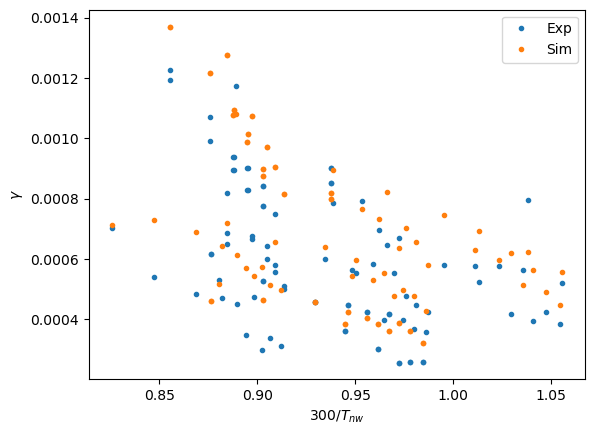

In [11]:

import matplotlib.pyplot as plt


inv_Tnw_vec = np.array([300/vec['Tnw'] for vec in exp_data_arr])

plt.figure
plt.plot(inv_Tnw_vec, gamma_exp_data, '.', label="Exp")
plt.plot(inv_Tnw_vec, gammas_sum_arr, '.', label="Sim")
plt.legend()
plt.xlabel(r"$300/T_{nw}$")
plt.ylabel(r"$\gamma$")


### other plots 


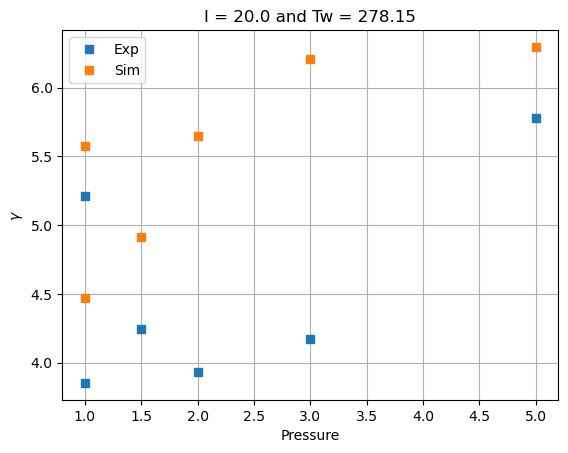

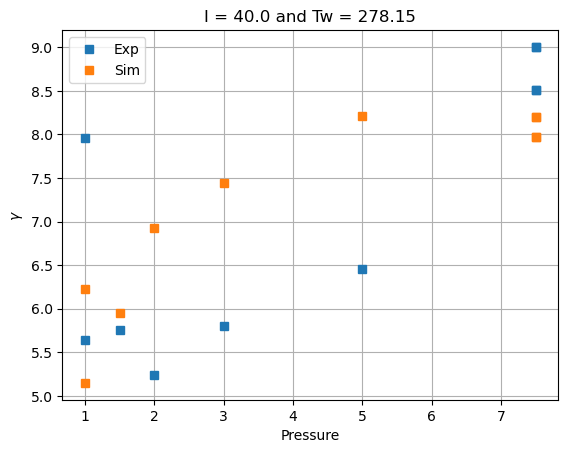

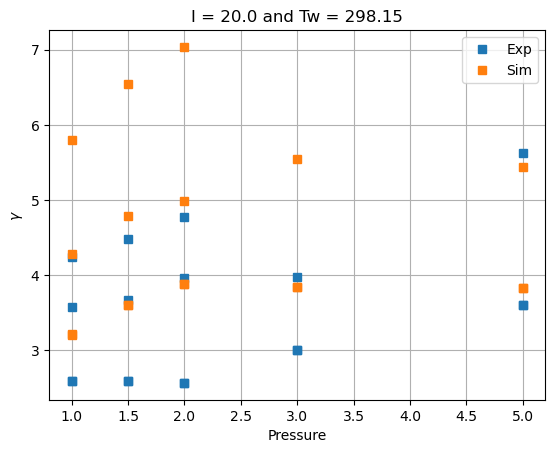

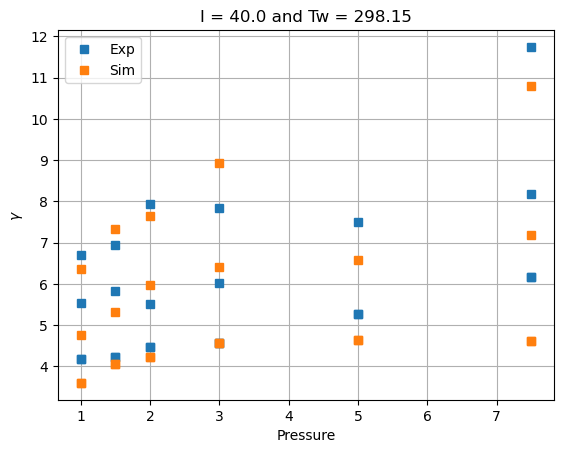

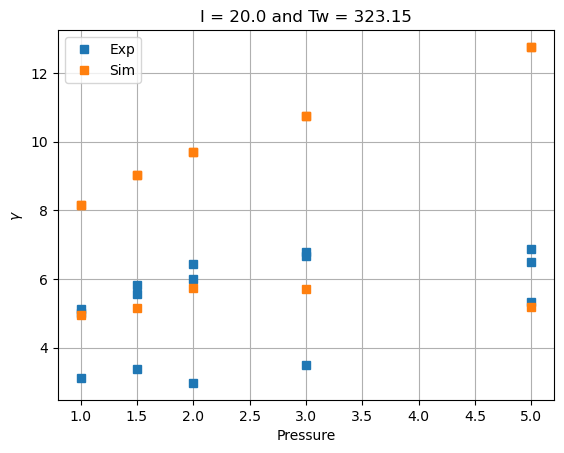

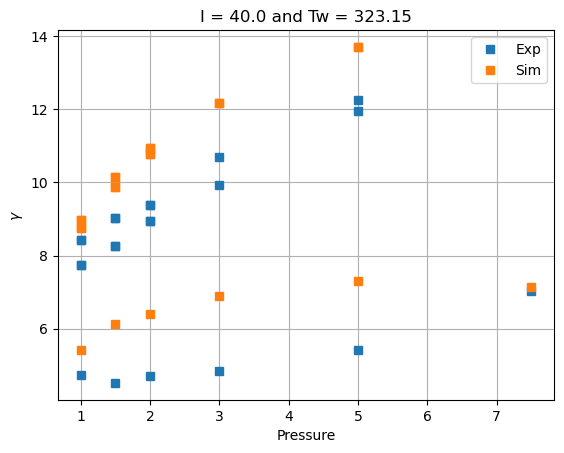

In [27]:
# print(exp_data_arr)

### sort by pressure 

current_vec = np.array([vec['current'] for vec in exp_data_arr])
Tw_vec = np.array([vec['Tw'] for vec in exp_data_arr])

current_unique = np.unique(current_vec)
Tw_unique = np.unique([vec['Tw'] for vec in exp_data_arr])


A, B = np.meshgrid(current_unique, Tw_unique)
combinations = np.stack([A.ravel(), B.ravel()], axis=1)

for comb in combinations:
    current = comb[0]
    Tw = comb[1]

    idx_valid = np.logical_and(current_vec == current, Tw_vec == Tw)
    data_arr = exp_data_arr[idx_valid]
    
    pressure_vec = np.array([vec['pressure'] for vec in data_arr])
    gamma_exp = gamma_exp_data[idx_valid]
    gamma_sim = gammas_sum_arr[idx_valid]
    
    plt.figure()
    plt.plot(pressure_vec, gamma_exp*1e4, 's', label="Exp")
    plt.plot(pressure_vec, gamma_sim*1e4, 's', label="Sim")
    plt.title(f"I = {current} and Tw = {Tw}")
    plt.xlabel("Pressure")
    plt.ylabel(r"$\gamma$")
    plt.legend()
    plt.grid()
    plt.show()


In [10]:


##### add the Error Propagation Class: error in model parameters and experimental data as well
### add the CO reactions